In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

24/02/01 13:59:51 WARN Utils: Your hostname, pedro resolves to a loopback address: 127.0.1.1; using 192.168.100.39 instead (on interface wlo1)
24/02/01 13:59:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/01 13:59:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
dados = spark.read.csv("data/imdb-reviews-pt-br.csv",
                       escape='\"',
                       header=True,
                       inferSchema=True)

# Explorando os dados

In [3]:
dados.limit(5).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
+---+--------------------+--------------------+---------+



In [4]:
print(f"Numero de linhas {dados.count()}, Numero de colunas: {len(dados.columns)}")

Numero de linhas 49459, Numero de colunas: 4


In [5]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



Filtrando comentarios negativos e positivos

In [6]:
print('Comentário negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate = False)
print('Comentário positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate = False)

Comentário negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                      

Contabilizando os dados

In [7]:
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



# Limpeza dos dados
- Retirando caracteres especiais e espaços de em branco
- Retirando as StopWords (preposições, pronomes)
- Normalização dos dados (variação de flexão, numero e grau)

In [8]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



## Word Cloud

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]


In [10]:
wordcloud = WordCloud(
background_color = 'white',
collocations = False, 
prefer_horizontal = 1,
width = 1000,
height = 600
).generate(str(tudo))

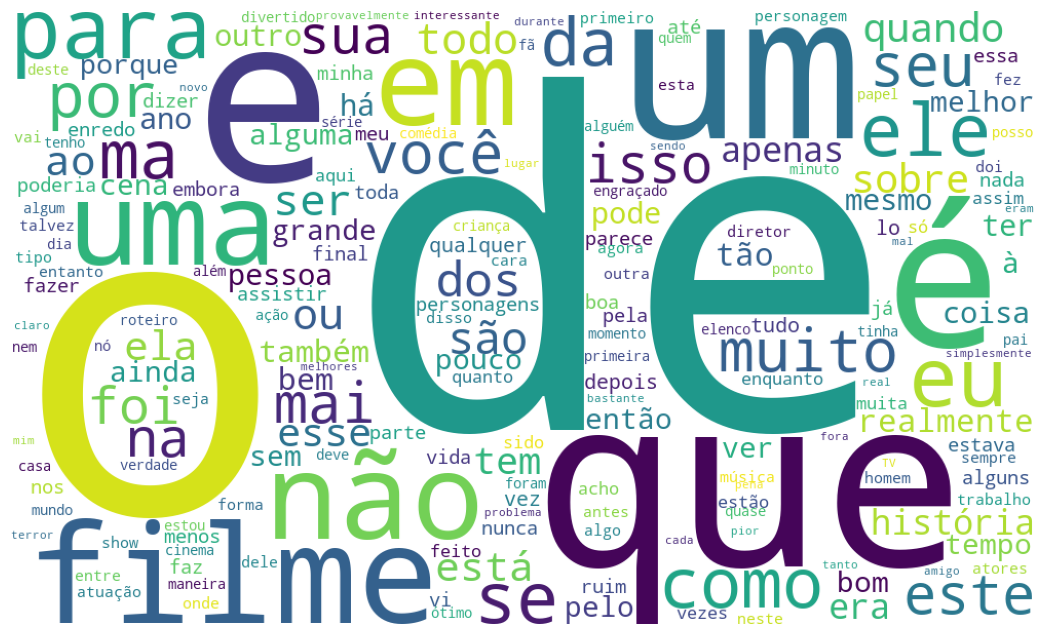

In [11]:
plt.figure(figsize = (20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Limpeza: caracteres especiais

In [12]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])


<>:8: SyntaxWarning: invalid escape sequence '\]'
<>:8: SyntaxWarning: invalid escape sequence '\]'
/tmp/ipykernel_18873/889012133.py:8: SyntaxWarning: invalid escape sequence '\]'
  ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),


In [14]:
import pyspark.sql.functions as f

amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_18873/1541428630.py:3: SyntaxWarning: invalid escape sequence '\$'
  amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))


In [15]:
amostra.show(truncate = False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



tirado espaços em branco 

In [16]:
amostra = amostra.withColumn('texto_limpo', f.trim(amostra.texto_regex))
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [17]:
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_18873/774157558.py:1: SyntaxWarning: invalid escape sequence '\$'
  dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))


In [18]:
dados.limit(5).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex))

# Tokenização

In [20]:
from pyspark.ml.feature import Tokenizer
tokenizer = Tokenizer(inputCol="texto_limpo",outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [21]:
tokenizado.select('texto_limpo','tokens').show(1,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------

In [22]:
from pyspark.sql.types import IntegerType
counttokens =  f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo","tokens").withColumn("Freq_tokens", counttokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

## StopWords 
-   São palavras vazias que não trazem nenhum sentido para nosso problema

In [23]:
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [24]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")
len(stop_A)

[nltk_data] Downloading package stopwords to /home/pedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


207

In [25]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")
len(stop_B)

203

In [26]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)

In [27]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords= stop_A)
df = remover.transform(tokenized)
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [28]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords= stop_B)
df = remover.transform(tokenized)
df.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [29]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")
feature_data = remover.transform(tokenizado)
feature_data.show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", counttokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", counttokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               73|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, w...|        308|              169|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               52|
|[this, german, ho...|[german, horror, ...|        156|               74|
|[being, a, longti...|[longtime, fan, j...|        136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

## Bag of Words

In [31]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")

model = cv.fit(df)
df = model.transform(df)

In [32]:
df.select("texto_final", "CountVec").show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,2,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,3,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [33]:
model.vocabulary

['spark', 'é', 'fácil', 'mllib', 'ajuda', 'nlp', 'ótimo']

## No dataframe real

In [34]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol = "texto_final", outputCol = "CountVec")

model = cv.fit(feature_data)

countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



24/02/01 14:00:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [35]:
model.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'first',
 'dont',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'say',
 'still',
 'end',
 'scene',
 'scenes',
 'man',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'thing',
 'actors',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'director',
 'quite',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'thought',
 'enough',
 'big',
 'world',
 'give',
 'horror',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'always',
 'long',
 'with

## Hashing TF
- Processo otimizado

In [36]:
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)
HTFfeaturizedData = hashingTF.transform(countVectorizer_features)


In [37]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



## TF-IDF

In [38]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [39]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Pipeline

In [40]:
TFIDFfeaturizedData.groupBy("sentiment").count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [41]:
from pyspark.ml.feature import StringIndexer

string_indexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = string_indexer.fit(dados).transform(dados)

In [42]:
dados.groupBy(["sentiment","label"]).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      neg|  0.0|24765|
|      pos|  1.0|24694|
+---------+-----+-----+



## Pipeline

In [43]:
from pyspark.ml.pipeline import Pipeline

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol = stopwords.getOutputCol(), outputCol = "HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf])

In [44]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [45]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

# Treinando um Modelo

In [46]:
featureDF = dados_transformados.select(["features", "label"])
featureDF.limit(5).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+



In [47]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [48]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import RandomForestClassifier


tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol = stopwords.getOutputCol(), outputCol = "HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")


dt = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth= 10, numTrees=30)

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfidf, dt])

In [49]:
train, test = dados.randomSplit([0.7, 0.3], seed=101)

In [50]:
dt_model = pipeline.fit(dados)

24/02/01 14:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1278.8 KiB
24/02/01 14:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1946.1 KiB
24/02/01 14:00:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [51]:
prediction = dt_model.transform(test)

In [52]:
prediction.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|[13.0317912525949...|[0.43439304175316...|       1.0|
|  6|A funny thing hap...|Um

24/02/01 14:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1901.4 KiB


# Teste e métricas

In [53]:
prediction.select("label","prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



24/02/01 14:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1869.6 KiB


In [54]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

acuracia = evaluator.evaluate(prediction)
print("Acuracia",acuracia)

24/02/01 14:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1886.5 KiB


Acuracia 0.7985357737104826


In [55]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

In [56]:
nova_class = dt_model.transform(nova_base)
nova_class.show()

24/02/01 14:00:30 WARN DAGScheduler: Broadcasting large task binary with size 1874.2 KiB
24/02/01 14:00:30 WARN DAGScheduler: Broadcasting large task binary with size 1874.2 KiB
24/02/01 14:00:30 WARN DAGScheduler: Broadcasting large task binary with size 1874.2 KiB


+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|[15.8819307104915...|[0.52939769034971...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[12.0833247010189...|[0.40277749003396...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+

